# Zadatak 2
#### Marko Šišović, 2024/3104

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
np.random.seed(42)

Učitajmo najpre podatke iz .csv datoteke. Podelićemo date podatke na matricu $x$, koja predstavlja matricu prediktora, kao i vektor $y$, koji predstavlja klasu. Dodatno, nasumično ćemo promešati date podatke, kao i podeliti ih na trening i test skup, u odnosu $80:20$. Na kraju koda ispisujemo dimenzionalnosti prethodno pomenutih elemenata, kako bismo se uverili u njihovo poklapanje.

In [5]:
data = np.loadtxt("../data-class.csv", delimiter=",")
x, y = data[:, :-1], data[:, -1]

split_ratio = 0.8

split_index = int(len(x) * split_ratio)

indices = np.random.permutation(len(x))
x, y = x[indices], y[indices]

x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(142, 5) (142,) (36, 5) (36,)


Glavni deo zadatka je napraviti klasifikator. Sa obzirom na parnost indeksa, koristićemo tri modela logističke regresije, pa za izabranu klasu uzimamo onu čiji je model najsigurniji u svoj izbor, to jest daje najveću vrednost na izlazu.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegressionMultiClass:
    def __init__(self, num_classes, num_features, alpha=0.01, mb=32, tolerance=1e-6):
        self.num_classes = num_classes
        self.num_features = num_features
        self.alpha = alpha
        self.mb = mb
        self.tolerance = tolerance
        self.weights = np.zeros((num_classes, num_features + 1))
        self.log_likelihoods = [[] for _ in range(num_classes)]
        self.epochs_per_class = [0] * num_classes

    def _add_bias(self, x):
        return np.hstack((np.ones((x.shape[0], 1)), x))

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _compute_gradient(self, x, y_one_hot, y_pred):
        return np.dot((y_one_hot - y_pred).T, x)

    def _compute_log_likelihood(self, x, y, weights):
        z = np.dot(x, weights.T)
        y_pred = self._sigmoid(z)
        return np.sum(y * np.log(y_pred + 1e-10) + (1 - y) * np.log(1 - y_pred + 1e-10))
    
    def _standardize(self, x, is_train=True):
        if is_train:
            self.mean = np.mean(x, axis=0)
            self.std = np.std(x, axis=0)
        return (x - self.mean) / (self.std + 1e-10)

    def fit(self, x, y, max_epochs=1000, converge_treshold = 10):
        x = self._standardize(x, is_train=True)
        x = self._add_bias(x)
        y_one_hot = np.eye(self.num_classes)[y.astype(int)]
        for class_index in range(self.num_classes):
            class_weights = self.weights[class_index]
            prev_log_likelihood = -np.inf
            converge_cnt = 0
            for _ in range(max_epochs):
                indices = np.random.permutation(len(x))
                x, y_one_hot = x[indices], y_one_hot[indices]
                y_binary = y_one_hot[:, class_index]
                
                start = 0
                end = start + self.mb
                x_batch, y_batch = x[start:end], y_binary[start:end]
                z = np.dot(x_batch, class_weights)
                y_pred = self._sigmoid(z)
                gradient = np.dot((y_batch - y_pred), x_batch)
                class_weights += self.alpha * gradient
                
                log_likelihood = self._compute_log_likelihood(x, y_binary, class_weights)
                self.log_likelihoods[class_index].append(log_likelihood)
                if np.abs(log_likelihood - prev_log_likelihood) < self.tolerance:
                    converge_cnt += 1
                    if converge_cnt >= converge_treshold:
                        break
                else:
                    converge_cnt
                prev_log_likelihood = log_likelihood
            self.epochs_per_class[class_index] = len(self.log_likelihoods[class_index])
            self.weights[class_index] = class_weights

    def predict(self, x):
        x = self._standardize(x, is_train=False)
        x = self._add_bias(x)
        z = np.dot(x, self.weights.T)
        y_pred = self._sigmoid(z)
        return np.argmax(y_pred, axis=1)

    def predict_proba(self, x):
        x = self._standardize(x, is_train=False)
        x = self._add_bias(x)
        z = np.dot(x, self.weights.T)
        return self._sigmoid(z)

Da bismo našli optimalne vrednosti hiperparametara $\alpha$ i $m_{mb}$, radićemo takozvani grid search, odnosno iterirati po mogućim vrednostima. Pošto će u nekim konfiguracijama model konvergirati do lokalnih umesto globalnih maksimuma, dodat je uslov da hiperparametri ne mogu biti optimalni ako funkcija verodostojnosti nije dovoljno blizu najbolje postignute.

In [32]:
num_classes = 3
num_features = x_train.shape[1]
alpha_arr = np.linspace(0.01, 5, 25)
mb_arr = np.linspace(1, 8, 8, dtype=int)
max_epochs = 10000
converge_treshold = 10
tolerance = 1e-6

log_likelihood_tolerance = 1
min_avg_iterations = np.inf
best_avg_log_likelihood = -np.inf
results = np.empty((0, 4))
for alpha in alpha_arr:
    for mb in mb_arr:
        model = LogisticRegressionMultiClass(num_classes, num_features, alpha, mb, tolerance)
        model.fit(x_train, y_train, max_epochs, converge_treshold)
        avg_iterations = np.mean(model.epochs_per_class)*mb
        avg_log_likelihood = np.mean([ll_arr[-1] for ll_arr in model.log_likelihoods])
        best_avg_log_likelihood = min(best_avg_log_likelihood, avg_log_likelihood)
        
        results = np.concatenate((results, np.array([[alpha, mb, avg_iterations, avg_log_likelihood]])), axis = 0)

best_avg_log_likelihood = np.max(results[:, 3])

condition = results[:, 3] > (best_avg_log_likelihood - log_likelihood_tolerance)
results = results[condition, :]
argmin_idx = np.argmin(results[:, 2])
alpha_best, mb_best, min_avg_iterations = results[argmin_idx, :3]
mb_best = int(mb_best)

print(alpha_best, mb_best, min_avg_iterations, best_avg_log_likelihood)

1.0495833333333333 3 2015.0 -5.091071187647702


Test Accuracy: 0.9444


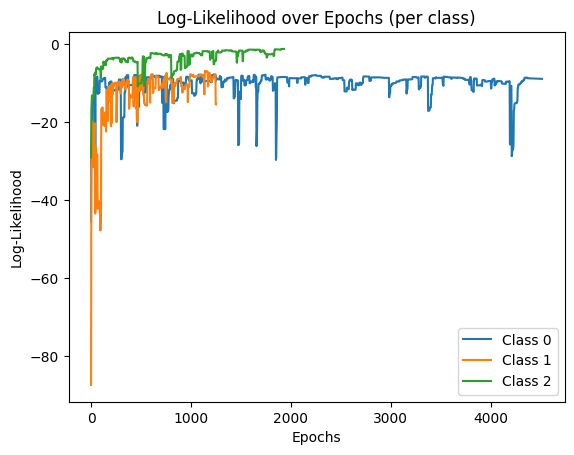

In [ ]:
model = LogisticRegressionMultiClass(num_classes, num_features, alpha_best, mb_best, tolerance)
model.fit(x_train, y_train, max_epochs, converge_treshold)

y_pred = model.predict(x_test)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

for class_index in range(num_classes):
    plt.plot(np.array(range(model.epochs_per_class[class_index]))*model.mb, model.log_likelihoods[class_index], label=f"Class {class_index}")
plt.xlabel("Epochs")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood over Epochs (per class)")
plt.legend()
plt.show()